Computed Homography =  [[ 6.62902260e-01  8.38251212e-02  2.13874406e+02]
 [ 2.41659187e-01  1.21239087e+00 -3.54678402e+01]
 [ 5.50956628e-04 -1.30944088e-05  1.00000000e+00]]
Provided Homography =     6.2544644e-01   5.7759174e-02   2.2201217e+02
   2.2240536e-01   1.1652147e+00  -2.5605611e+01
   4.9212545e-04  -3.6542424e-05   1.0000000e+00



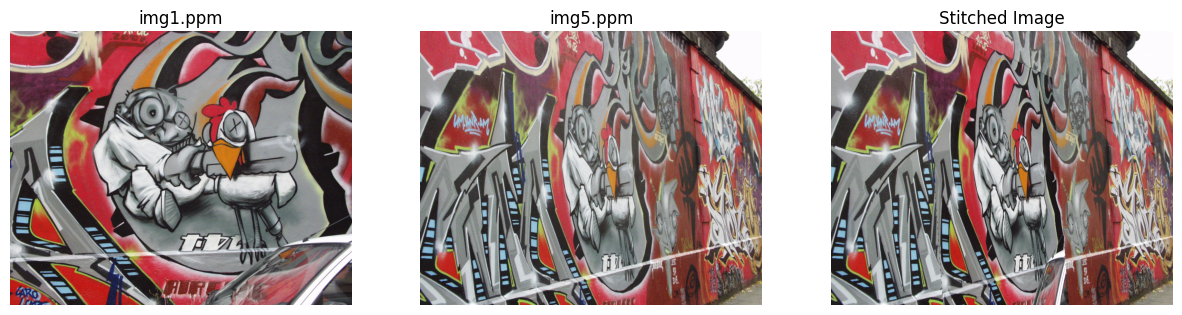

In [41]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

images = []
gray_images = []

file_names = ['img1.ppm', 'img2.ppm', 'img3.ppm', 'img4.ppm', 'img5.ppm']

for file_name in file_names:
    img = cv.imread('images/graf/'+file_name)
    gray_img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    images.append(img)
    gray_images.append(gray_img)

def random_number(n, t):
    l = np.random.randint(n,size =t)
    m = np.zeros((np.shape(l)))

    for i in range(len(l)):
        m[i] = np.sum(l == l[i])
    if np.sum(m) == len(m):
        return l
    else:
        return random_number(n,t)

def calculateHomography(p1,p2):
    x1,y1,x2,y2,x3,y3,x4,y4 = p2[0], p2[1], p2[2], p2[3], p2[4], p2[5], p2[6], p2[7]
    x1T,x2T,x3T,x4T = p1[0], p1[1], p1[2], p1[3]
    zero_matrix = np.array([[0],[0],[0]])

    matrix_A = np.concatenate((np.concatenate((zero_matrix.T,x1T,-y1*x1T), axis=1), np.concatenate((x1T,zero_matrix.T,-x1*x1T), axis=1),
                               np.concatenate((zero_matrix.T,x2T,-y2*x2T), axis=1), np.concatenate((x2T,zero_matrix.T,-x2*x2T), axis=1),
                                np.concatenate((zero_matrix.T,x3T,-y3*x3T), axis=1), np.concatenate((x3T,zero_matrix.T,-x3*x3T), axis=1),
                                np.concatenate((zero_matrix.T,x4T,-y4*x4T), axis=1), np.concatenate((x4T,zero_matrix.T,-x4*x4T), axis=1)), axis=0)
    W,v = np.linalg.eig(((matrix_A.T)@matrix_A))
    temph = v[:,np.argmin(W)]
    H = temph.reshape((3,3))
    return H

p, sampleSize, outlierRatio= 0.99, 4, 0.5
N = int(np.ceil(np.log(1-p)/np.log(1-(1-outlierRatio)**sampleSize)))
Hs = []

for i in range(4):
    sift = cv.SIFT_create()
    key_points_1, descriptors_1 = sift.detectAndCompute(gray_images[i],None)
    key_points_5, descriptors_5 = sift.detectAndCompute(gray_images[i+1],None)
    bf_match = cv.BFMatcher(cv.NORM_L1, crossCheck=True)
    matches = sorted(bf_match.match(descriptors_1,descriptors_5), key = lambda x:x.distance)

    Source_points = [key_points_1[k.queryIdx].pt for k in matches]
    Destination_points = [key_points_5[k.trainIdx].pt for k in matches]
    threshold, best_inliers, best_H = 2, 0, 0

    for i in range(N):
        ran_points = random_number(len(Source_points)-1,4)
        f_points =[]
        for j in range(4):
            f_points.append(np.array([[Source_points[ran_points[j]][0], Source_points[ran_points[j]][1], 1]]))

        t_points =[]
        for j in range(4):
            t_points.append(Destination_points[ran_points[j]][0])
            t_points.append(Destination_points[ran_points[j]][1])
        
        H = calculateHomography(f_points,t_points)

        inliers = 0
        for k in range(len(Source_points)):
            X = [Source_points[k][0],Source_points[k][1],1]
            HX = H @ X
            HX /= HX[-1]
            err = np.sqrt((np.power(HX[0] - Destination_points[k][0],2) + np.power(HX[1] - Destination_points[k][1],2)))
            if err < threshold:
                inliers += 1
        if inliers > best_inliers:
            best_inliers = inliers
            best_H = H
    Hs.append(best_H)
H1_H5 = Hs[3]@Hs[2]@Hs[1]@Hs[0]
H1_H5 /= H1_H5[-1][-1]

print("Computed Homography = ", H1_H5)
print("Provided Homography = ", open("H1to5p", 'r').read())

img_p = cv.warpPerspective(images[0], H1_H5, (images[4].shape[1], images[4].shape[0]))
ret, threshold = cv.threshold(img_p, 10, 1, cv.THRESH_BINARY_INV)
img2_thresholded = np.multiply(threshold, images[4])
img_blended = cv.addWeighted(img2_thresholded, 1, img_p, 1, 0)

fig, ax = plt.subplots(1, 3, figsize=(15, 12))
ax[0].imshow(cv.cvtColor(images[0], cv.COLOR_BGR2RGB))
ax[0].set_title("img1.ppm")
ax[0].axis("off")
ax[1].imshow(cv.cvtColor(images[4], cv.COLOR_BGR2RGB))
ax[1].set_title("img5.ppm")
ax[1].axis("off")
ax[2].imshow(cv.cvtColor(img_blended, cv.COLOR_BGR2RGB))
ax[2].set_title("Stitched Image")
ax[2].axis("off")

plt.show()
